In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_json(r"C:\Users\Shaikh Abdul Rafay\Desktop\cash_forcasting_data\cashInfo-1001.json" , lines= True) 
# df2 = pd.read_json(r"C:\Users\Shaikh Abdul Rafay\Desktop\cash_forcasting_data\cashInfo-1002.json" , lines= True) 
# df3 = pd.read_json(r"C:\Users\Shaikh Abdul Rafay\Desktop\cash_forcasting_data\cashInfo-1003.json" , lines= True) 
# df4 = pd.read_json(r"C:\Users\Shaikh Abdul Rafay\Desktop\cash_forcasting_data\cashInfo-1004.json" , lines= True) 
# df5 = pd.read_json(r"C:\Users\Shaikh Abdul Rafay\Desktop\cash_forcasting_data\cashInfo-1005.json" , lines= True) 
# df = pd.concat([df1, df2, df3,df4 , df5], axis=0)
# df.reset_index(drop=True, inplace=True)
df.tail()

,ATMId,Id,RecTime,Type1Count,Type2Count,Type3Count,Type4Count,TotalValue,IsHoliday,HolidayType
1637,1001,1638,2024-06-25T00:00:00,4,19,9,3,35,False,None
1638,1001,1639,2024-06-26T00:00:00,4,29,5,8,46,False,None
1639,1001,1640,2024-06-27T00:00:00,28,11,14,3,56,False,None
1640,1001,1641,2024-06-28T00:00:00,19,9,6,2,36,False,None
1641,1001,1642,2024-06-29T00:00:00,15,1,17,8,41,True,SS


In [4]:
print("DataFrame Information:")
print("-" * 30)
print('DF Shape: ' ,df.shape)
print('number of Columns: ' ,len(df.columns))
print('number of Observations: ' ,len(df))
print('Number of values in df: ' , df.count().sum())
print('Total Number of Missing values in df: ' , df.isna().sum().sum())
print('percentage of Missing values : ' ,  "{:.2f}".format(df.isna().sum().sum()/df.count().sum() *100),'%')
print('Total Number of Duplicated records in df : ' , df.duplicated().sum().sum())
print('percentage of Duplicated values : ' ,  "{:.2f}".format(df.duplicated().sum().sum()/df.count().sum() *100),'%')

DataFrame Information:
------------------------------
DF Shape:  (1642, 10)
number of Columns:  10
number of Observations:  1642
Number of values in df:  15247
Total Number of Missing values in df:  1173
percentage of Missing values :  7.69 %
Total Number of Duplicated records in df :  0
percentage of Duplicated values :  0.00 %


# Feature Engineering

In [5]:
#processing_dates
df['RecTime'] = pd.to_datetime(df['RecTime'])
df = df.sort_values(by='RecTime')
df['Year'] = df['RecTime'].dt.year
df['Month'] = df['RecTime'].dt.month
df['Date'] = df['RecTime'].dt.day
df['DayOfWeek'] = df['RecTime'].dt.dayofweek
df['IsWeekend'] = df['RecTime'].dt.dayofweek >= 5
df['Quarter'] = df['RecTime'].dt.quarter
df['DayOfYear'] = df['RecTime'].dt.dayofyear
df['PartOfMonth'] = df['RecTime'].dt.day.apply(lambda day: '1' if day <= 10 else ('2' if day <= 20 else '3'))


df.drop(['ATMId' , 'Id' , 'HolidayType' ] , axis= 1 , inplace= True)
df.head(10)
df = df.fillna(0)

In [9]:
df['PartOfMonth'].value_counts()

PartOfMonth
3    562
1    540
2    540
Name: count, dtype: int64

In [47]:
# Convert counts to Cash Amounts
def convert(t1 = 100 , t2 = 500 , t3 = 1000 , t4 = 5000):
    df['Type1Value'] = t1 * df['Type1Count']
    df['Type2Value'] = t2 * df['Type2Count']
    df['Type3Value'] = t3 * df['Type3Count']
    df['Type4Value'] = t4 * df['Type4Count']
    df['TotalValue'] = df['Type1Value'] + df['Type2Value'] + df['Type3Value'] + df['Type4Value'] 
    

convert ()

In [48]:
usd = pd.read_csv(r"C:\Users\Shaikh Abdul Rafay\Downloads\USD_PKR Historical Data.csv")
usd['RecTime'] = pd.to_datetime(usd["Date"])
usd

,Date,Price,Open,High,Low,Vol.,Change %,RecTime
0,06/28/2024,278.200,279.100,279.100,278.300,NaN,-0.07%,2024-06-28
1,06/27/2024,278.400,279.075,279.115,278.375,NaN,0.00%,2024-06-27
2,06/26/2024,278.400,279.025,279.100,278.400,NaN,-0.16%,2024-06-26
3,06/25/2024,278.840,279.475,279.475,278.425,NaN,-0.10%,2024-06-25
4,06/24/2024,279.120,279.425,279.475,278.500,NaN,0.40%,2024-06-24
...,...,...,...,...,...,...,...,...
1198,01/06/2020,154.470,154.500,155.480,154.490,0.12K,-0.26%,2020-01-06
1199,01/04/2020,154.875,154.875,154.875,154.875,NaN,0.28%,2020-01-04
1200,01/03/2020,154.450,155.000,155.170,154.490,0.11K,-0.10%,2020-01-03
1201,01/02/2020,154.600,154.870,155.240,154.410,0.15K,0.08%,2020-01-02


In [49]:
# Converting PKR to USD for more stability
def convert_to_usd(date, total_value):
    
    price_row = usd[usd['RecTime'] <= date]
    
    if not price_row.empty:
        latest_price_row = price_row.sort_values(by='RecTime', ascending=False).iloc[0]
        price = latest_price_row['Price']
        return total_value / price
    else:
        return None

df['TotalValueUSD'] = df.apply(lambda row: convert_to_usd(row['RecTime'], row['TotalValue']), axis=1)
df['Last7Days_mean'] = df['TotalValueUSD'].rolling(window=7, min_periods=1).mean().shift(1)
df['Last30Days_mean'] = df['TotalValueUSD'].rolling(window=30, min_periods=1).mean().shift(1)
df['Difference'] = df['TotalValueUSD'].shift(1) - df['TotalValueUSD'].shift(2)

In [50]:
# Adding Public Holdidays
public_holidays = {
    '2020-02-05': 'Kashmir Day',
    '2020-03-23': 'Pakistan Day',
    '2020-05-01': 'Labour Day',
    '2020-05-24': 'Eid-ul-Fitr Day 1',
    '2020-05-25': 'Eid-ul-Fitr Day 2',
    '2020-05-26': 'Eid-ul-Fitr Day 3',
    '2020-07-31': 'Eid al-Adha Day 1',
    '2020-08-01': 'Eid al-Adha Day 2',
    '2020-08-02': 'Eid al-Adha Day 3',
    '2020-08-14': 'Independence Day',
    '2020-08-28': 'Ashura',
    '2020-08-29': 'Ashura',
    '2020-10-29': 'Eid Milad un-Nabi',
    '2020-11-09': 'Iqbal Day',
    '2020-12-25': 'Christmas Day',
    '2020-12-25': 'Quaid-e-Azam Day',


    '2021-02-05': 'Kashmir Day',
    '2021-03-23': 'Pakistan Day',
    '2021-05-01': 'Labour Day',
    '2021-05-13': 'Eid-ul-Fitr Day 1',
    '2021-05-14': 'Eid-ul-Fitr Day 2',
    '2021-05-15': 'Eid-ul-Fitr Day 3',
    '2021-07-20': 'Eid al-Adha Day 1',
    '2021-07-21': 'Eid al-Adha Day 2',
    '2021-07-22': 'Eid al-Adha Day 3',
    '2021-08-14': 'Independence Day',
    '2021-08-18': 'Ashura',
    '2021-08-19': 'Ashura',
    '2021-10-19': 'Eid Milad un-Nabi',
    '2021-11-09': 'Iqbal Day',
    '2021-12-25': 'Christmas Day',
    '2021-12-25': 'Quaid-e-Azam Day',
    

    '2022-02-05': 'Kashmir Day',
    '2022-03-23': 'Pakistan Day',
    '2022-05-01': 'Labour Day',
    '2022-05-03': 'Eid-ul-Fitr Day 1',
    '2022-05-04': 'Eid-ul-Fitr Day 2',
    '2022-05-05': 'Eid-ul-Fitr Day 3',
    '2022-07-10': 'Eid-ul-Azha Day 1',
    '2022-07-11': 'Eid-ul-Azha Day 2',
    '2022-07-12': 'Eid-ul-Azha Day 3',
    '2022-08-07': 'Ashura',
    '2022-08-08': 'Ashura',
    '2022-08-14': 'Independence Day',
    '2022-10-09': 'Eid Milad-un-Nabi',
    '2022-12-25': 'Quaid-e-Azam Day',

    '2023-02-05': 'Kashmir Day',
    '2023-03-23': 'Pakistan Day',
    '2023-04-22': 'Eid ul-Fitr Day 1',
    '2023-04-23': 'Eid ul-Fitr Day 2',
    '2023-04-24': 'Eid ul-Fitr Day 3',    
    '2023-05-01': 'Labour Day',
    '2023-06-29': 'Eid ul-Azha Day 1',
    '2023-06-30': 'Eid ul-Azha Day 2',
    '2023-07-1': 'Eid ul-Azha Day 2',
    '2023-07-28': 'Ashura',
    '2023-07-29': 'Ashura',
    '2023-08-14': 'Independence Day',
    '2023-09-28': 'Eid Milad un-Nabi',
    '2023-11-09': 'Iqbal Day',
    '2023-12-25': 'Quaid-e-Azam Day',

    '2024-02-05': 'Kashmir Day',
    '2024-03-23': 'Pakistan Day',
    '2024-05-01': 'Labour Day',
    '2024-05-03': 'Eid ul-Fitr Day 1',
    '2024-05-04': 'Eid ul-Fitr Day 2',
    '2024-05-05': 'Eid ul-Fitr Day 3',
    '2024-07-16': 'Eid ul-Azha Day 1',
    '2024-07-17': 'Eid ul-Azha Day 2',
    '2024-07-18': 'Eid ul-Azha Day 3',
    '2024-08-07': 'Ashura',
    '2024-08-08': 'Ashura',
    '2024-08-14': 'Independence Day',
    '2024-09-28': 'Eid Milad un-Nabi',
    '2024-11-09': 'Iqbal Day',
    '2024-12-25': 'Quaid-e-Azam Day',
    '2024-12-26': 'Day after Christmas',

    '2024-01-01': 'New Year’s Day',
    '2024-02-05': 'Kashmir Day',
    '2024-03-23': 'Pakistan Day',
    '2024-05-01': 'Labour Day',
    '2024-05-03': 'Eid ul-Fitr Day 1',
    '2024-05-04': 'Eid ul-Fitr Day 2',
    '2024-05-05': 'Eid ul-Fitr Day 3'
}
df['HolidayType'] = None
df['IsHoliday'] = False

    # Add 'HolidayType' based on 'RecTime'
df['HolidayType'] = df['RecTime'].apply(lambda x: public_holidays.get(x.strftime('%Y-%m-%d'), None))
df['IsHoliday'] = df['HolidayType'].notna()
df.loc[df['IsWeekend'], 'IsHoliday'] = True


df.loc[df['RecTime'].between(pd.to_datetime('2024-2-8') ,pd.to_datetime('2024-2-9') ), 'HolidayType'] = 'Elections'
df

,RecTime,Type1Count,Type2Count,Type3Count,Type4Count,TotalValue,IsHoliday,Year,Month,Date,...,PartOfMonth,Type1Value,Type2Value,Type3Value,Type4Value,TotalValueUSD,Last7Days_mean,Last30Days_mean,Difference,HolidayType
0,2020-01-01,24,32,13,1,36400,False,2020,1,1,...,1,2400,16000,13000,5000,235.644462,NaN,NaN,NaN,None
1,2020-01-02,35,17,10,9,67000,False,2020,1,2,...,1,3500,8500,10000,45000,433.376455,235.644462,235.644462,NaN,None
2,2020-01-03,4,22,16,7,62400,False,2020,1,3,...,1,400,11000,16000,35000,404.014244,334.510459,334.510459,197.731994,None
3,2020-01-04,13,13,17,6,54800,True,2020,1,4,...,1,1300,6500,17000,30000,353.833737,357.678387,357.678387,-29.362211,None
4,2020-01-05,1,21,2,8,52600,True,2020,1,5,...,1,100,10500,2000,40000,339.628733,356.717225,356.717225,-50.180507,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,2024-06-25,4,19,9,3,33900,False,2024,6,25,...,3,400,9500,9000,15000,121.575097,153.173812,157.319774,-137.729060,None
1638,2024-06-26,4,29,5,8,59900,False,2024,6,26,...,3,400,14500,5000,40000,215.158046,145.482630,159.995461,42.397682,None
1639,2024-06-27,28,11,14,3,37300,False,2024,6,27,...,3,2800,5500,14000,15000,133.979885,140.659371,159.654815,93.582949,None
1640,2024-06-28,19,9,6,2,22400,False,2024,6,28,...,3,1900,4500,6000,10000,80.517613,151.885685,158.845031,-81.178161,None


In [51]:
df[df['HolidayType'].notna()]


,RecTime,Type1Count,Type2Count,Type3Count,Type4Count,TotalValue,IsHoliday,Year,Month,Date,...,PartOfMonth,Type1Value,Type2Value,Type3Value,Type4Value,TotalValueUSD,Last7Days_mean,Last30Days_mean,Difference,HolidayType
35,2020-02-05,39,20,11,8,64900,True,2020,2,5,...,1,3900,10000,11000,40000,422.856398,272.088948,296.724312,137.585391,Kashmir Day
82,2020-03-23,10,14,13,0,21000,True,2020,3,23,...,3,1000,7000,13000,0,133.079848,287.998139,294.063537,194.690265,Pakistan Day
121,2020-05-01,26,28,19,6,65600,True,2020,5,1,...,1,2600,14000,19000,30000,410.000000,221.649128,253.032315,-180.941943,Labour Day
144,2020-05-24,14,35,17,9,80900,True,2020,5,24,...,3,1400,17500,17000,45000,504.836193,324.369715,283.051693,-162.870515,Eid-ul-Fitr Day 1
145,2020-05-25,26,23,5,3,34100,True,2020,5,25,...,3,2600,11500,5000,15000,212.064677,366.260567,295.229664,193.447738,Eid-ul-Fitr Day 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2024-03-23,12,11,2,4,28700,True,2024,3,23,...,3,1200,5500,2000,20000,103.274559,131.971686,153.754679,-86.784652,Pakistan Day
1582,2024-05-01,13,12,5,6,42300,True,2024,5,1,...,1,1300,6000,5000,30000,152.158273,183.356696,166.011606,76.300121,Labour Day
1584,2024-05-03,35,12,14,5,48500,True,2024,5,3,...,1,3500,6000,14000,25000,174.429060,161.875684,165.098996,-8.787810,Eid ul-Fitr Day 1
1585,2024-05-04,37,28,11,8,68700,True,2024,5,4,...,1,3700,14000,11000,40000,247.077864,160.719304,168.478107,31.058596,Eid ul-Fitr Day 2


In [52]:
import pandas as pd
# Adding Religious Festivals

df['RecTime'] = pd.to_datetime(df['RecTime'])
ramzan_ranges = [
    (pd.to_datetime('2020-04-24'), pd.to_datetime('2020-05-23')),
    (pd.to_datetime('2021-04-13'), pd.to_datetime('2021-05-12')),
    (pd.to_datetime('2022-04-02'), pd.to_datetime('2022-05-01')),
    (pd.to_datetime('2023-03-22'), pd.to_datetime('2023-04-21')),
    (pd.to_datetime('2024-03-11'), pd.to_datetime('2024-04-09'))
]

hajj_ranges = [
    (pd.to_datetime('2020-07-22'), pd.to_datetime('2020-07-31')),
    (pd.to_datetime('2021-07-11'), pd.to_datetime('2021-07-20')),
    (pd.to_datetime('2022-06-30'), pd.to_datetime('2022-07-09')),
    (pd.to_datetime('2023-06-19'), pd.to_datetime('2023-06-28')),
    (pd.to_datetime('2024-06-07'), pd.to_datetime('2024-06-16'))
]

muharram_ranges = [
    (pd.to_datetime('2020-08-20'), pd.to_datetime('2020-09-18')),
    (pd.to_datetime('2021-08-10'), pd.to_datetime('2021-09-08')),
    (pd.to_datetime('2022-07-31'), pd.to_datetime('2022-08-28')),
    (pd.to_datetime('2023-07-21'), pd.to_datetime('2023-08-19')),
    (pd.to_datetime('2024-07-10'), pd.to_datetime('2024-08-08'))
]



df['Event'] = "Nothing"

for start, end in ramzan_ranges:
    df.loc[df['RecTime'].between(start, end), 'Event'] = 'Ramzan'


for start, end in hajj_ranges:
    df.loc[df['RecTime'].between(start, end), 'Event'] = 'Hajj'
    
for start, end in muharram_ranges:
    df.loc[df['RecTime'].between(start, end), 'Event'] = 'Muharram'



In [53]:
import plotly.graph_objects as go

# Convert 'RecTime' to datetime
df['RecTime'] = pd.to_datetime(df['RecTime'])

# Filter data for the year 2020
df_2020 = df[df['RecTime'].dt.year == 2021]

# Initialize the figure
fig = go.Figure()

# Add a trace for the year 2020
fig.add_trace(go.Scatter(x=df_2020['RecTime'], y=df_2020['TotalValueUSD'], mode='lines', name='2020'))

# Add event annotations using the HolidayType column
events = df_2020[df_2020['HolidayType'].notnull()]

for _, event in events.iterrows():
    fig.add_annotation(
        x=event['RecTime'],
        y=event['TotalValueUSD'],
        text=event['HolidayType'],
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-30
    )

# Update layout
fig.update_layout(
    title='Total Value in 2020',
    xaxis_title='Date',
    yaxis_title='Total Value',
)

fig.show()


In [54]:
# Adding PayDays
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay

all_paydays = []

for year in range(2020, 2025):
    paydays_year = []
    
    for month in range(1, 13):
        month_dates = pd.date_range(start=f'{year}-{month:02d}-01', end=f'{year}-{month:02d}-10')
        paydays_year.append(pd.DataFrame({'RecTime': month_dates}))

    paydays_year = pd.concat(paydays_year, ignore_index=True)
    weekmask = 'Mon Tue Wed Thu Fri'
    bday = CustomBusinessDay(weekmask=weekmask)
    paydays_year['RecTime'] = paydays_year['RecTime'] + bday
    
    all_paydays.append(paydays_year)

all_paydays = pd.concat(all_paydays, ignore_index=True)
all_paydays['RecTime'] = pd.to_datetime(all_paydays['RecTime'])
df['Paydays'] = False

# Mark paydays in 'Paydays' column of df
df.loc[df['RecTime'].isin(all_paydays['RecTime']), 'Paydays'] = True

df.head(10)


,RecTime,Type1Count,Type2Count,Type3Count,Type4Count,TotalValue,IsHoliday,Year,Month,Date,...,Type2Value,Type3Value,Type4Value,TotalValueUSD,Last7Days_mean,Last30Days_mean,Difference,HolidayType,Event,Paydays
0,2020-01-01,24,32,13,1,36400,False,2020,1,1,...,16000,13000,5000,235.644462,NaN,NaN,NaN,None,Nothing,False
1,2020-01-02,35,17,10,9,67000,False,2020,1,2,...,8500,10000,45000,433.376455,235.644462,235.644462,NaN,None,Nothing,True
2,2020-01-03,4,22,16,7,62400,False,2020,1,3,...,11000,16000,35000,404.014244,334.510459,334.510459,197.731994,None,Nothing,True
3,2020-01-04,13,13,17,6,54800,True,2020,1,4,...,6500,17000,30000,353.833737,357.678387,357.678387,-29.362211,None,Nothing,False
4,2020-01-05,1,21,2,8,52600,True,2020,1,5,...,10500,2000,40000,339.628733,356.717225,356.717225,-50.180507,None,Nothing,False
5,2020-01-06,3,1,17,9,62800,False,2020,1,6,...,500,17000,45000,406.551434,353.299526,353.299526,-14.205004,None,Nothing,True
6,2020-01-07,15,18,11,2,31500,False,2020,1,7,...,9000,11000,10000,203.777979,362.174844,362.174844,66.922701,None,Nothing,True
7,2020-01-08,10,31,9,9,70500,False,2020,1,8,...,15500,9000,45000,456.310680,339.546721,339.546721,-202.773455,None,Nothing,True
8,2020-01-09,6,17,11,4,40100,False,2020,1,9,...,8500,11000,20000,260.389610,371.070466,354.142215,252.532701,None,Nothing,True
9,2020-01-10,5,38,5,6,54500,False,2020,1,10,...,19000,5000,30000,352.979275,346.358060,343.725259,-195.921069,None,Nothing,True


In [55]:
# Holidays Sequence For knowing long weekends
def get_sequence(is_holiday_series):
    sequence = []
    n = len(is_holiday_series)
    for i in range(n):
        if i == 0:  
            seq = ('H' if is_holiday_series[i] else 'W')
        elif i == 1:  
            seq = ('H' if is_holiday_series[i-1] else 'W') + ('H' if is_holiday_series[i] else 'W')
        elif i == n-1:  
            seq = ('H' if is_holiday_series[i-1] else 'W') + ('H' if is_holiday_series[i] else 'W')
        elif i == n-2:  
            seq = (
                ('H' if is_holiday_series[i-1] else 'W') +
                ('H' if is_holiday_series[i] else 'W') +
                ('H' if is_holiday_series[i+1] else 'W')
            )
        else:   
            seq = (
                ('H' if is_holiday_series[i-1] else 'W') +
                ('H' if is_holiday_series[i] else 'W') +
                ('H' if is_holiday_series[i+1] else 'W') +
                ('H' if is_holiday_series[i+2] else 'W')
            )
        sequence.append(seq)
    return sequence

df['HolidaySequence'] = get_sequence(df['IsHoliday'])


In [56]:
df.head(10)

,RecTime,Type1Count,Type2Count,Type3Count,Type4Count,TotalValue,IsHoliday,Year,Month,Date,...,Type3Value,Type4Value,TotalValueUSD,Last7Days_mean,Last30Days_mean,Difference,HolidayType,Event,Paydays,HolidaySequence
0,2020-01-01,24,32,13,1,36400,False,2020,1,1,...,13000,5000,235.644462,NaN,NaN,NaN,None,Nothing,False,W
1,2020-01-02,35,17,10,9,67000,False,2020,1,2,...,10000,45000,433.376455,235.644462,235.644462,NaN,None,Nothing,True,WW
2,2020-01-03,4,22,16,7,62400,False,2020,1,3,...,16000,35000,404.014244,334.510459,334.510459,197.731994,None,Nothing,True,WWHH
3,2020-01-04,13,13,17,6,54800,True,2020,1,4,...,17000,30000,353.833737,357.678387,357.678387,-29.362211,None,Nothing,False,WHHW
4,2020-01-05,1,21,2,8,52600,True,2020,1,5,...,2000,40000,339.628733,356.717225,356.717225,-50.180507,None,Nothing,False,HHWW
5,2020-01-06,3,1,17,9,62800,False,2020,1,6,...,17000,45000,406.551434,353.299526,353.299526,-14.205004,None,Nothing,True,HWWW
6,2020-01-07,15,18,11,2,31500,False,2020,1,7,...,11000,10000,203.777979,362.174844,362.174844,66.922701,None,Nothing,True,WWWW
7,2020-01-08,10,31,9,9,70500,False,2020,1,8,...,9000,45000,456.310680,339.546721,339.546721,-202.773455,None,Nothing,True,WWWW
8,2020-01-09,6,17,11,4,40100,False,2020,1,9,...,11000,20000,260.389610,371.070466,354.142215,252.532701,None,Nothing,True,WWWH
9,2020-01-10,5,38,5,6,54500,False,2020,1,10,...,5000,30000,352.979275,346.358060,343.725259,-195.921069,None,Nothing,True,WWHH


In [57]:
df.columns

Index(['RecTime', 'Type1Count', 'Type2Count', 'Type3Count', 'Type4Count',
       'TotalValue', 'IsHoliday', 'Year', 'Month', 'Date', 'DayOfWeek',
       'IsWeekend', 'Quarter', 'DayOfYear', 'PartOfMonth', 'Type1Value',
       'Type2Value', 'Type3Value', 'Type4Value', 'TotalValueUSD',
       'Last7Days_mean', 'Last30Days_mean', 'Difference', 'HolidayType',
       'Event', 'Paydays', 'HolidaySequence'],
      dtype='object')

In [58]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ft = ['IsHoliday','HolidayType','DayOfWeek','Event' , 'Paydays' , 'HolidaySequence' , 'IsWeekend','PartOfMonth' ]
for i in ft:
    df[i] = le.fit_transform(df[i])

df

y1 = df.pop('Type1Count')
y2 = df.pop('Type2Count')
y3 = df.pop('Type3Count')
y4 = df.pop('Type4Count')
df.drop(['Type1Value', 'Type2Value', 'Type3Value', 'Type4Value'] , inplace= True, axis= 1)


In [59]:
import pandas as pd

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the correlations with TotalValue
correlations_with_total_value = correlation_matrix['TotalValue']

# Extract the correlations with TotalValueUSD
correlations_with_total_value_usd = correlation_matrix['TotalValueUSD']

# Combine correlations into a single DataFrame
correlation_df_total_value = pd.DataFrame({
    'Feature': correlations_with_total_value.index,
    'Correlation with TotalValue': correlations_with_total_value.values,
    'Correlation with TotalValueUSD': correlations_with_total_value_usd.values
})

# Sort the DataFrame by the absolute value of 'Correlation with TotalValue'
correlation_df_total_value = correlation_df_total_value.sort_values(
    by='Correlation with TotalValue', 
    key=lambda x: x.abs(), 
    ascending=False
)

# Display the DataFrame
correlation_df_total_value


,Feature,Correlation with TotalValue,Correlation with TotalValueUSD
1,TotalValue,1.000000,0.844630
11,TotalValueUSD,0.844630,1.000000
8,Quarter,-0.047382,-0.068939
4,Month,-0.044985,-0.070410
9,DayOfYear,-0.043911,-0.069532
14,Difference,-0.039453,-0.034988
15,HolidayType,0.035385,0.031495
13,Last30Days_mean,0.031311,0.504044
0,RecTime,-0.030859,-0.496163
12,Last7Days_mean,0.028637,0.452912


In [60]:
df.columns

Index(['RecTime', 'TotalValue', 'IsHoliday', 'Year', 'Month', 'Date',
       'DayOfWeek', 'IsWeekend', 'Quarter', 'DayOfYear', 'PartOfMonth',
       'TotalValueUSD', 'Last7Days_mean', 'Last30Days_mean', 'Difference',
       'HolidayType', 'Event', 'Paydays', 'HolidaySequence'],
      dtype='object')

In [61]:
df

,RecTime,TotalValue,IsHoliday,Year,Month,Date,DayOfWeek,IsWeekend,Quarter,DayOfYear,PartOfMonth,TotalValueUSD,Last7Days_mean,Last30Days_mean,Difference,HolidayType,Event,Paydays,HolidaySequence
0,2020-01-01,36400,0,2020,1,1,2,0,1,1,0,235.644462,NaN,NaN,NaN,25,2,0,8
1,2020-01-02,67000,0,2020,1,2,3,0,1,2,0,433.376455,235.644462,235.644462,NaN,25,2,1,14
2,2020-01-03,62400,0,2020,1,3,4,0,1,3,0,404.014244,334.510459,334.510459,197.731994,25,2,1,16
3,2020-01-04,54800,1,2020,1,4,5,1,1,4,0,353.833737,357.678387,357.678387,-29.362211,25,2,0,11
4,2020-01-05,52600,1,2020,1,5,6,1,1,5,0,339.628733,356.717225,356.717225,-50.180507,25,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,2024-06-25,33900,0,2024,6,25,1,0,2,177,2,121.575097,153.173812,157.319774,-137.729060,25,2,0,19
1638,2024-06-26,59900,0,2024,6,26,2,0,2,178,2,215.158046,145.482630,159.995461,42.397682,25,2,0,19
1639,2024-06-27,37300,0,2024,6,27,3,0,2,179,2,133.979885,140.659371,159.654815,93.582949,25,2,0,18
1640,2024-06-28,22400,0,2024,6,28,4,0,2,180,2,80.517613,151.885685,158.845031,-81.178161,25,2,0,15


In [62]:
df = df.rename(columns={'RecTime': 'ds', 'TotalValueUSD': 'y'})
df.drop('TotalValue' , inplace = True , axis=1)

In [63]:
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

In [64]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Assuming df has a 'TotalValue_diff' column for differenced data
# # If you haven't differenced the data, do so


# # Split the data into train and test sets
# train_size = int(len(df) * 0.8)
# train, test = df['TotalValue_diff'][:train_size], df['TotalValue_diff'][train_size:]

# # Fit ARIMA model
# model = ARIMA(train, order=(1, 1, 1))
# fitted_model = model.fit()

# # Forecast
# forecast_result = fitted_model.get_forecast(steps=len(test))
# forecast = forecast_result.predicted_mean
# conf_int = forecast_result.conf_int(alpha=0.05)

# # Create a DataFrame to hold the forecasted values and the actual test values
# forecast_df = pd.DataFrame({
#     'actual': test,
#     'forecast': forecast
# })

# # Plotting the results
# fig = make_subplots(rows=1, cols=1)

# # Actual values
# fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Actual'), row=1, col=1)

# # Forecasted values
# fig.add_trace(go.Scatter(x=test.index, y=forecast, mode='lines', name='Forecast'), row=1, col=1)

# # Confidence intervals
# fig.add_trace(go.Scatter(
#     x=test.index,
#     y=conf_int.iloc[:, 0],
#     mode='lines',
#     line=dict(width=0),
#     showlegend=False
# ), row=1, col=1)

# fig.add_trace(go.Scatter(
#     x=test.index,
#     y=conf_int.iloc[:, 1],
#     mode='lines',
#     fill='tonexty',
#     name='Confidence Interval',
#     line=dict(width=0),
#     showlegend=True
# ), row=1, col=1)

# # Update layout
# fig.update_layout(title='Actual vs Forecasted Values', xaxis_title='Date', yaxis_title='Total Value')

# fig.show()

# # Calculate accuracy metrics
# mae = mean_absolute_error(test, forecast)
# mse = mean_squared_error(test, forecast)
# rmse = np.sqrt(mse)

# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')


In [82]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prophet import Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

future = model.make_future_dataframe(periods=len(df_test))

forecast = model.predict(future)
y_pred = forecast['yhat'].iloc[-len(df_test):].values
y_true = df_test['y'].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

y_pred = forecast['yhat'].iloc[-len(df_test):].values
# Plotting True vs Predicted values using Plotly
fig = make_subplots(rows=1, cols=1)

# Add true values trace
fig.add_trace(
    go.Scatter(x=df_test['ds'], y=y_true, mode='lines', name='True Values', line=dict(color='blue')),
    row=1, col=1
)

# Add predicted values trace
fig.add_trace(
    go.Scatter(x=df_test['ds'], y=y_pred, mode='lines', name='Predicted Values', line=dict(color='red')),
    row=1, col=1
)

# Update layout
fig.update_layout(
    title='True vs Predicted Values Using Prophet',
    xaxis_title='Date',
    yaxis_title='Values',
    legend=dict(x=0, y=1.0)
)

fig.show()


19:48:26 - cmdstanpy - INFO - Chain [1] start processing
19:48:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 62.15
Mean Squared Error (MSE): 5862.80
Root Mean Squared Error (RMSE): 76.57


In [66]:
df = df.dropna()
y = df.pop('y')
ds = df.pop('ds')

In [67]:
from sklearn.model_selection import train_test_split 
xtrain , xtest , ytrain , ytest = train_test_split(df , y , train_size= 0.8)

In [68]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error
# from scipy.stats import randint, uniform


# # Define the Gradient Boosting Regressor
# gbm = GradientBoostingRegressor()

# # Define the parameter grid
# param_distributions = {
#     'n_estimators': randint(50, 500),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(3, 15),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 20),
#     'subsample': uniform(0.5, 0.5)
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     gbm,
#     param_distributions,
#     n_iter=100,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV
# random_search.fit(xtrain, ytrain)

# # Best parameters
# print("Best Parameters:", random_search.best_params_)

# # Best model
# best_model = random_search.best_estimator_

# # Evaluate the model
# y_pred = best_model.predict(xtest)
# mse = mean_squared_error(ytest, y_pred)
# print("Mean Squared Error on Test Data:", mse)


In [69]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# from scipy.stats import randint, uniform

# xgb = XGBRegressor()

# # Define the hyperparameter grid
# param_distributions = {
#     'n_estimators': randint(50, 500),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(3, 15),
#     'min_child_weight': randint(1, 10),
#     'subsample': uniform(0.5, 0.5),
#     'colsample_bytree': uniform(0.5, 0.5),
#     'gamma': uniform(0, 1)
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     xgb,
#     param_distributions,
#     n_iter=100,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV
# random_search.fit(xtrain, ytrain)
# 1
# # Best parameters
# print("Best Parameters:", random_search.best_params_)

# # Best model
# best_model = random_search.best_estimator_

# # Evaluate the model
# xg_pred = best_model.predict(xtest)
# mse = mean_squared_error(ytest, y_pred)
# print("Mean Squared Error on Test Data:", mse)


In [70]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from scipy.stats import randint, uniform

# rf = RandomForestRegressor()

# # Define the hyperparameter grid
# param_distributions = {
#     'n_estimators': randint(50, 500),
#     'max_depth': randint(3, 20),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 20),
#     'bootstrap': [True, False],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     rf,
#     param_distributions,
#     n_iter=100,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit RandomizedSearchCV
# random_search.fit(xtrain, ytrain)

# # Best parameters
# print("Best Parameters:", random_search.best_params_)

# # Best model
# best_model = random_search.best_estimator_

# # Evaluate the model
# rf_pred = best_model.predict(xtest)
# mse = mean_squared_error(ytest, y_pred)
# print("Mean Squared Error on Test Data:", mse)


In [71]:
# fig = make_subplots(rows=1, cols=1)

# # Add true values trace
# fig.add_trace(
#     go.Scatter(x=df_test['ds'], y=y, mode='lines', name='True Values', line=dict(color='blue')),
#     row=1, col=1
# )

# # Add predicted values trace
# fig.add_trace(
#     go.Scatter(x=df_test['ds'], y=xg_pred, mode='lines', name='Gradient Boost Tuned Predicted Values', line=dict(color='red' , dash='dash')),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=df_test['ds'], y=gb_pred, mode='lines', name='XGBoost Tuned Predicted Values', line=dict(color='yellow' , dash='dash')),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=df_test['ds'], y=rf_pred, mode='lines', name='RandomForest Tuned Predicted Values', line=dict(color='green', dash='dash' )),
#     row=1, col=1
# )


# # Update layout
# fig.update_layout(
#     title='True vs Predicted Values Using Gradient Boost',
#     xaxis_title='Date',
#     yaxis_title='Values',
#     legend=dict(x=0, y=1.0)
# )
# print('llll')
# fig.show()

In [72]:
# from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error , r2_score

# models = {
#     'Random Forest': rf_pred,
#     'Gradient Boost': gb_pred,
#     'XGBoost': xg_pred
# }

# # Calculate and display metrics for each model
# for var_name, predictions in models.items():
#     mse = mean_squared_error(ytest, predictions)
#     mae = mean_absolute_error(ytest, predictions)
#     mape = mean_absolute_percentage_error(ytest, predictions)
#     r2 = r2_score(ytest, predictions)
    
#     print(f"Variable Name: {var_name}")
#     print(f"MSE: {mse:.4f}")
#     print(f"MAE: {mae:.4f}")
#     print(f"MAPE: {mape:.2f}%")
#     print(f"R²: {r2:.4f}")
#     print()


In [73]:
# import pandas as pd
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Initialize CatBoostRegressor
# catboost_model = CatBoostRegressor()

# # Define the parameter grid
# param_grid = {
#     'iterations': [500, 1000, 1500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8, 10],
#     'l2_leaf_reg': [1, 3, 5, 7, 9]
# }

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)

# # Fit RandomizedSearchCV
# random_search.fit(xtrain, ytrain)

# # Best parameters
# print(f'Best parameters found by RandomizedSearchCV: {random_search.best_params_}')

# # Predict using the best estimator
# catboost_pred = random_search.best_estimator_.predict(xtest)

# # Evaluation
# mse = mean_squared_error(ytest, catboost_pred)
# mae = mean_absolute_error(ytest, catboost_pred)
# r2 = r2_score(ytest, catboost_pred)

# print(f'CatBoost MSE: {mse}')
# print(f'CatBoost MAE: {mae}')
# print(f'CatBoost R2: {r2}')


In [74]:
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Initialize LightGBM Regressor
# lgbm_model = lgb.LGBMRegressor()

# # Define the parameter grid
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 500, 1000],
#     'min_child_samples': [20, 30, 40],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)

# # Fit RandomizedSearchCV
# random_search.fit(xtrain, ytrain)

# # Best parameters
# print(f'Best parameters found by RandomizedSearchCV: {random_search.best_params_}')

# # Predict using the best estimator
# lgbm_pred = random_search.best_estimator_.predict(xtest)

# # Evaluation
# mse = mean_squared_error(ytest, lgbm_pred)
# mae = mean_absolute_error(ytest, lgbm_pred)
# r2 = r2_score(ytest, lgbm_pred)

# print(f'LightGBM MSE: {mse}')
# print(f'LightGBM MAE: {mae}')
# print(f'LightGBM R2: {r2}')




In [75]:
# test = pd.read_csv(r"C:\Users\Shaikh Abdul Rafay\Desktop\ATM Cash Forecast\ATM-Cash-Forecast\App\cashInfo-1006processed.csv")
# test['RecTime'] = pd.to_datetime(test['RecTime'])


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# ft = ['IsHoliday','HolidayType','DayOfWeek','Event' , 'Paydays' , 'HolidaySequence' , 'IsWeekend','PartOfMonth' ]
# for i in ft:
#     test[i] = le.fit_transform(test[i])



# y1 = test.pop('Type1Count')
# y2 = test.pop('Type2Count')
# y3 = test.pop('Type3Count')
# y4 = test.pop('Type4Count')
# ds = test.pop('RecTime')
# test.drop(['Type1Value', 'Type2Value', 'Type3Value', 'Type4Value' , 'TotalValue' , 'Unnamed: 0'	,] , inplace= True, axis= 1)


In [76]:
# test = test.dropna()
# ytest = test.pop('TotalValueUSD')
# test.shape
# ytest.shape

In [77]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
gb = GradientBoostingRegressor(
    learning_rate =  0.01687770422304368,
    max_depth = 3,
    min_samples_leaf = 4,
    min_samples_split = 19,
    n_estimators = 409,
    subsample = 0.8776807051588262)
lgbm= lgb.LGBMRegressor(
    subsample=0.9,
    num_leaves=31,
    n_estimators=500,
    min_child_samples=40,
    learning_rate=0.01,
    colsample_bytree=0.7
)
cb = CatBoostRegressor(
    learning_rate=0.01,
    l2_leaf_reg=3,
    iterations=1000,
    depth=4,
    verbose=0
)
rf = RandomForestRegressor(
    bootstrap=True,
    max_depth=19,
    max_features='auto',
    min_samples_leaf=9,
    min_samples_split=13,
    n_estimators=314
)
xgb = XGBRegressor(
    colsample_bytree=0.7845407345828739,
    gamma=0.06351182959000135,
    learning_rate=0.017364373527198277,
    max_depth=3,
    min_child_weight=5,
    n_estimators=360,
    subsample=0.9323611881275267
)

preds = []



for i in [gb , lgbm , cb , rf , xgb]:
    i.fit(xtrain , ytrain)
    preds.append(i.predict(xtest))





[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 16
[LightGBM] [Info] Start training from score 221.283878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example data (Replace with actual data)
# X_train, X_test, y_train, y_test should be defined here

# Define base models with the provided parameters
base_models = [
    ('rf', RandomForestRegressor(
        bootstrap=True,
        max_depth=19,
        max_features='auto',
        min_samples_leaf=9,
        min_samples_split=13,
        n_estimators=314
    )),
    ('gb', GradientBoostingRegressor(
        learning_rate=0.01687770422304368,
        max_depth=3,
        min_samples_leaf=4,
        min_samples_split=19,
        n_estimators=409,
        subsample=0.8776807051588262
    )),
    ('xgb', XGBRegressor(
        colsample_bytree=0.7845407345828739,
        gamma=0.06351182959000135,
        learning_rate=0.017364373527198277,
        max_depth=3,
        min_child_weight=5,
        n_estimators=360,
        subsample=0.9323611881275267
    )),
    ('catboost', CatBoostRegressor(
        learning_rate=0.01,
        l2_leaf_reg=3,
        iterations=1000,
        depth=4,
        verbose=0
    )),
    ('lgbm', lgb.LGBMRegressor(
        subsample=0.9,
        num_leaves=31,
        n_estimators=500,
        min_child_samples=40,
        learning_rate=0.01,
        colsample_bytree=0.7
    ))
]

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacked_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

# Train Stacked Regressor
stacked_regressor.fit(xtrain, ytrain)

# Make predictions
preds.append(stacked_regressor.predict(xtest))




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 16
[LightGBM] [Info] Start training from score 221.283878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [1]:
df.columns

NameError: name 'df' is not defined

In [79]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Assuming you have rf_pred, gb_pred, xg_pred, catboost_pred, and lgbm_pred
preds.append(np.mean(preds, axis=0))
preds.append(np.max(preds, axis=0))
models = [
    'Gradient Boost',
    'LightGBM',
    'CatBoost',
    'Random Forest',
    'XGBoost',
    'Stacked Reg',
    'Average',
    'Max'
]

# List to store the evaluation metrics
metrics = []

# Calculate and store metrics for each model
for var_name, predictions in zip(models , preds):
    mse = mean_squared_error(ytest, predictions)
    mae = mean_absolute_error(ytest, predictions)
    mape = mean_absolute_percentage_error(ytest, predictions)
    r2 = r2_score(ytest, predictions)
    
    metrics.append({
        'Model': var_name,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    })

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
metrics_df


,Model,MSE,MAE,MAPE,R²
0,Gradient Boost,8153.120910,74.120546,0.519558,0.246021
1,LightGBM,8331.395676,74.694458,0.516761,0.229534
2,CatBoost,8008.748305,73.221282,0.513698,0.259372
3,Random Forest,8185.164058,74.258579,0.519106,0.243057
4,XGBoost,8114.376399,73.988787,0.516712,0.249604
5,Stacked Reg,8039.253855,73.694420,0.516420,0.256551
6,Average,8066.996742,73.823733,0.516243,0.253985
7,Max,8167.027422,74.381897,0.542696,0.244735


In [80]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(models), cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add traces for each model
for i, model in enumerate(models):
    fig.add_trace(
        go.Scatter(y=ytest, mode='lines', name='True Values', line=dict(color='blue') , showlegend=False) ,
        row=i+1, col=1
    )
    
    fig.add_trace(
        go.Scatter(y=preds[i], mode='lines', name=f'{model} Predicted Values', line=dict(color='red'), showlegend=False),
        row=i+1, col=1
    )
    fig.update_yaxes(title_text=model, row=i+1, col=1)

# Update layout
fig.update_layout(
    title='True vs Predicted Values for Different Models',
    

    legend=dict(x=0, y=1.0),
    height=3000  # Adjust height as needed
)

# Save to HTML
fig.write_html('true_vs_predicted_models.html')

# Show the plot
fig.show()

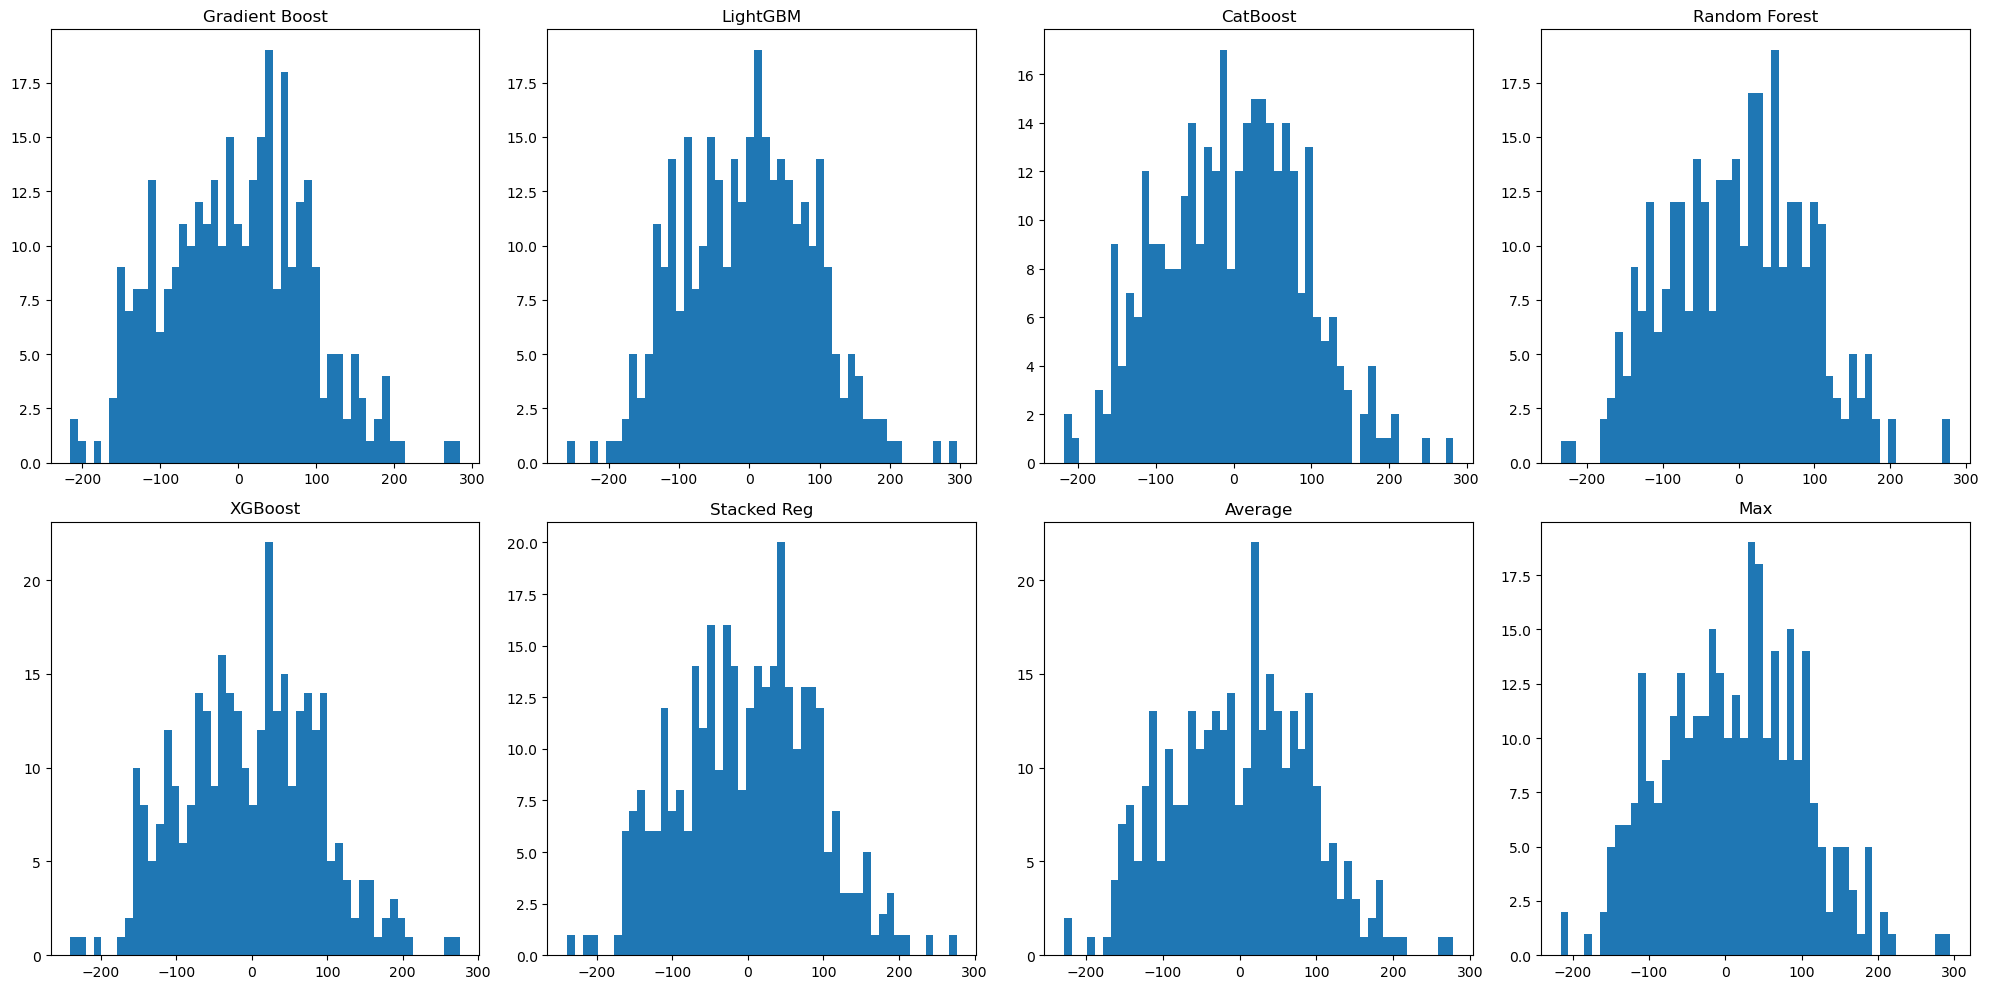

In [81]:
import matplotlib.pyplot as plt

# Assuming preds is a list of predictions for each model in the following order
# preds = [gb_pred, lgbm_pred, cb_pred, rf_pred, xg_pred, stacked_pred, avg_pred, max_pred]

# Calculate errors for each model
errors_list = [preds[0] - ytest, preds[1] - ytest, preds[2] - ytest, preds[3] - ytest, preds[4] - ytest, preds[5] - ytest, preds[6] - ytest, preds[7] - ytest]

# Titles for the models in the specified order
models = [
    'Gradient Boost',
    'LightGBM',
    'CatBoost',
    'Random Forest',
    'XGBoost',
    'Stacked Reg',
    'Average',
    'Max'
]

# Create subplots
f, a = plt.subplots(2, 4, figsize=(20, 10))
a = a.ravel()

# Plot histograms
for idx, ax in enumerate(a):
    ax.hist(errors_list[idx], bins=50)
    ax.set_title(models[idx])

plt.tight_layout()
plt.show()
